In [9]:
import os
import numpy
from matplotlib import pyplot as plt
import sys
import pandas as pd
import csv
from mpl_toolkits.mplot3d import Axes3D
#sys.path.insert(0, r'/Users/nenetto/Dev/BiiGTK/src/PythonTools')
%matplotlib inline

In [10]:
rotation_file = '/Users/nenetto/Trabajo/AlgiaCervical/DataTestInclinometro/movement_data.csv'

# Read by rows
import csv
csvfile = open(rotation_file, 'rb')
spamreader = csv.reader(csvfile, delimiter=',')

names = spamreader.next()
time = spamreader.next()
angleExtracted = spamreader.next()
xangle = spamreader.next()
yangle = spamreader.next()
zangle = spamreader.next()

print len(time), len(time), len(angleExtracted), len(xangle), len(yangle), len(zangle)

1253 1253 1253 1253 1253 1253


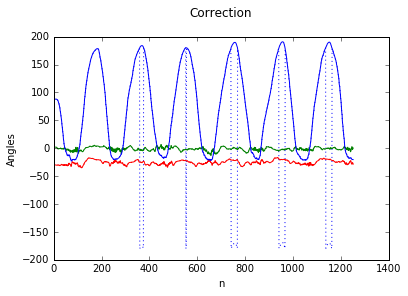

In [78]:
rotation_file = '/Users/nenetto/Trabajo/AlgiaCervical/DataTestInclinometro/movement_data.csv'

# Read by rows
import csv
csvfile = open(rotation_file, 'rb')
spamreader = csv.reader(csvfile, delimiter=',')

names = spamreader.next()
time = spamreader.next()
angleExtracted = spamreader.next()
xangle = spamreader.next()
yangle = spamreader.next()
zangle = spamreader.next()

# Number of points
N = len(time)

eulerAng = numpy.zeros((5,N))

eulerAng[0,:] = numpy.array(xangle)
eulerAng[1,:] = numpy.array(yangle)
eulerAng[2,:] = numpy.array(zangle)
eulerAng[3,:] = numpy.array(angleExtracted)
eulerAng[4,:] = numpy.array(time)

    
    
    

def correctAngles(x,y,z):
    
    dvx = x[1::] - x[0:-1]
    dvx = numpy.concatenate(([0.0],dvx),0)
    thresholdx = numpy.median(dvx) + 5 * numpy.std(dvx)
    dvx = numpy.abs(dvx)
    
    dvy = numpy.diff(y)
    dvy = numpy.concatenate(([0.0],dvy),0)
    thresholdy = numpy.median(dvy) + 5 * numpy.std(dvy)
    dvy = numpy.abs(dvy)
    
    dvz = numpy.diff(z)
    dvz = numpy.concatenate(([0.0],dvz),0)
    thresholdz = numpy.median(dvz) + 5 * numpy.std(dvz)
    dvz = numpy.abs(dvz)
    

    threshold = numpy.max(numpy.array([thresholdx, thresholdy, thresholdz]))
    
    signx = 1
    signy = 1
    signz = 1
    
    
    cx = numpy.copy(x)
    cy = numpy.copy(y)
    cz = numpy.copy(z)
    
    
    for i in range(len(x)):
        
        if dvx[i] > threshold:
            signx = signx * (-1)
            
        if dvy[i] > threshold:
            signy = signz * (-1)
            
        if dvz[i] > threshold:
            signz = signz * (-1)
            
            
        if signx == (-1):
            cx[i] = x[i] + 360
            
        if signy == (-1):
            cy[i] = y[i] + 360
            
        if signz == (-1):
            cz[i] = z[i] + 360

    return cx,cy,cz
    
    
    
   



# Correct all angles

x = eulerAng[0,:] 
y = eulerAng[1,:] 
z = eulerAng[2,:] 


cx,cy,cz = correctAngles(x,y,z)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,'r', ls = ':')
ax.plot(y,'g', ls = ':')
ax.plot(z,'b', ls = ':')
ax.plot(cx,'r')
ax.plot(cy,'g')
ax.plot(cz,'b')
ax.set_xlabel('n')
ax.set_ylabel('Angles')
ax.set_title('Correction\n')
plt.show()


In [70]:
a = numpy.array([1,2,3])
print a[1::] - a[0:-1]
print numpy.diff(a)

[1 1]
[1 1]


In [38]:
print a

[ True False False]


In [42]:
print numpy.concatenate(([True],a),0)

[ True  True False False]
